In [28]:
import os
import pandas as pd
import numpy as np

import nibabel as nib
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, balanced_accuracy_score

In [29]:
path_to_data = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data"

id_types = {"participant_id": str,
            "session": int,
            "acq": int,
            "run": int}

df = pd.read_csv(os.path.join(path_to_data, "processed", "ausz_t1mri_participants.csv"), dtype=id_types)
scheme = pd.read_csv(os.path.join(path_to_data, "schemes", "nss_stratified_10_fold_ausz.csv"), dtype=id_types)

## Exploring data

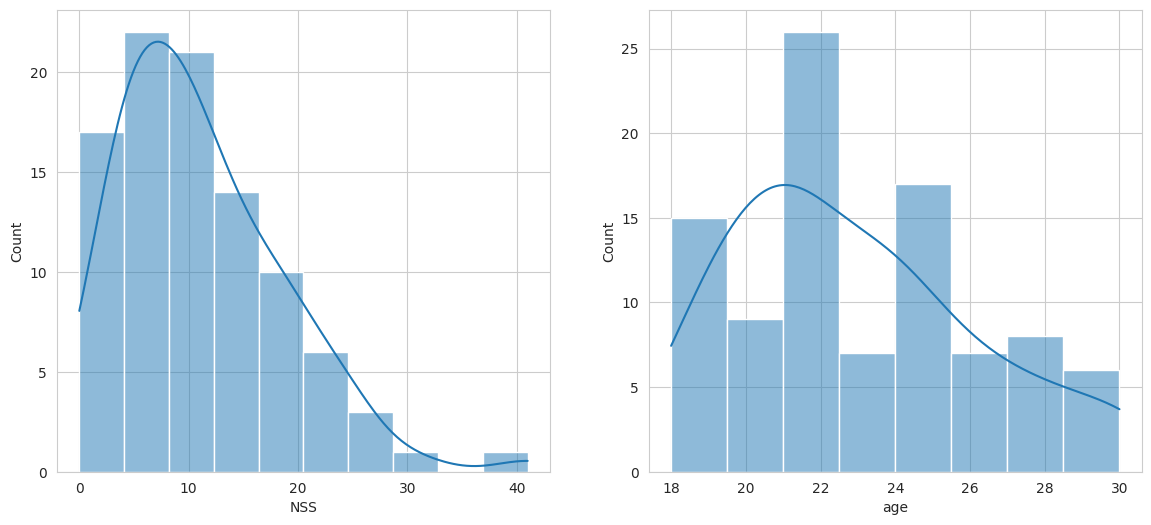

In [30]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(data=df, x="NSS", kde=True, ax=ax[0])
    sns.histplot(data=df, x="age", kde=True, ax=ax[1])
plt.show()

In [31]:
df["NSS"].describe()

count    95.000000
mean     11.157895
std       7.541115
min       0.000000
25%       5.500000
50%       9.500000
75%      15.000000
max      41.000000
Name: NSS, dtype: float64

In [32]:
df["age"].describe()

count    95.000000
mean     22.884211
std       3.257930
min      18.000000
25%      20.500000
50%      22.000000
75%      25.000000
max      30.000000
Name: age, dtype: float64

In [33]:
df["sex"].value_counts()

sex
M    80
F    15
Name: count, dtype: int64

In [34]:
df["diagnosis"].value_counts()

diagnosis
control    26
asd        25
scz        24
scz-asd    20
Name: count, dtype: int64

In [35]:
df[["diagnosis", "age", "sex", "NSS"]].groupby("diagnosis").describe()

age                                                        NSS  \
          count       mean       std   min    25%   50%    75%   max count   
diagnosis                                                                    
asd        25.0  21.960000  2.978814  18.0  20.00  21.0  24.00  30.0  25.0   
control    26.0  23.153846  2.948794  19.0  21.00  23.0  24.75  30.0  26.0   
scz        24.0  23.708333  3.735600  18.0  20.75  24.0  26.25  30.0  24.0   
scz-asd    20.0  22.700000  3.294333  18.0  19.75  22.0  26.00  28.0  20.0   

                                                                 
                mean       std  min     25%    50%    75%   max  
diagnosis                                                        
asd        17.200000  6.253332  9.0  11.500  18.00  21.00  31.0  
control     5.153846  3.665431  0.0   2.625   4.25   7.50  13.5  
scz        10.791667  5.996225  2.0   5.875   9.50  15.25  23.0  
scz-asd    11.850000  8.527201  4.0   5.875  10.00  14.50  41.0

In [36]:
df[["diagnosis", "sex"]].groupby("diagnosis").value_counts(normalize=True)

diagnosis  sex
asd        M      0.880000
           F      0.120000
control    M      0.807692
           F      0.192308
scz        M      0.875000
           F      0.125000
scz-asd    M      0.800000
           F      0.200000
Name: proportion, dtype: float64

## Per fold 

### Stratification on diagnosis, sex and age

In [19]:
nss = {"fold":[], "split":[], "mean": [], "std": []}
age = {"fold":[], "split":[], "mean": [], "std": []}
sex = {"fold":[], "split":[], "proportion": []}
diag = {"fold":[], "split":[], "proportion": []}

for fold in range(10):

    for split in ("train", "test"):
        
        # print("\nfold", fold, split, len(df.loc[scheme[f"fold{fold}"]==split]))
        
        nss["fold"].append(fold)
        nss["split"].append(split)
        nss["mean"].append(df.loc[scheme[f"fold{fold}"]==split, "NSS"].mean())
        nss["std"].append(df.loc[scheme[f"fold{fold}"]==split, "NSS"].std())

        age["fold"].append(fold)
        age["split"].append(split)
        age["mean"].append(df.loc[scheme[f"fold{fold}"]==split, "age"].mean())
        age["std"].append(df.loc[scheme[f"fold{fold}"]==split, "age"].std())

        sex["fold"].append(fold)
        sex["split"].append(split)
        sex["proportion"].append(df.loc[scheme[f"fold{fold}"]==split, ["sex"]].value_counts(normalize=True).get("F", 0))

        diag["fold"].append(fold)
        diag["split"].append(split)
        diag["proportion"].append(df.loc[scheme[f"fold{fold}"]==split, ["diagnosis"]].value_counts(normalize=True).get("control", 0))

nss_df = pd.DataFrame(nss)
age_df = pd.DataFrame(age)
sex_df = pd.DataFrame(sex)
diag_df = pd.DataFrame(diag)

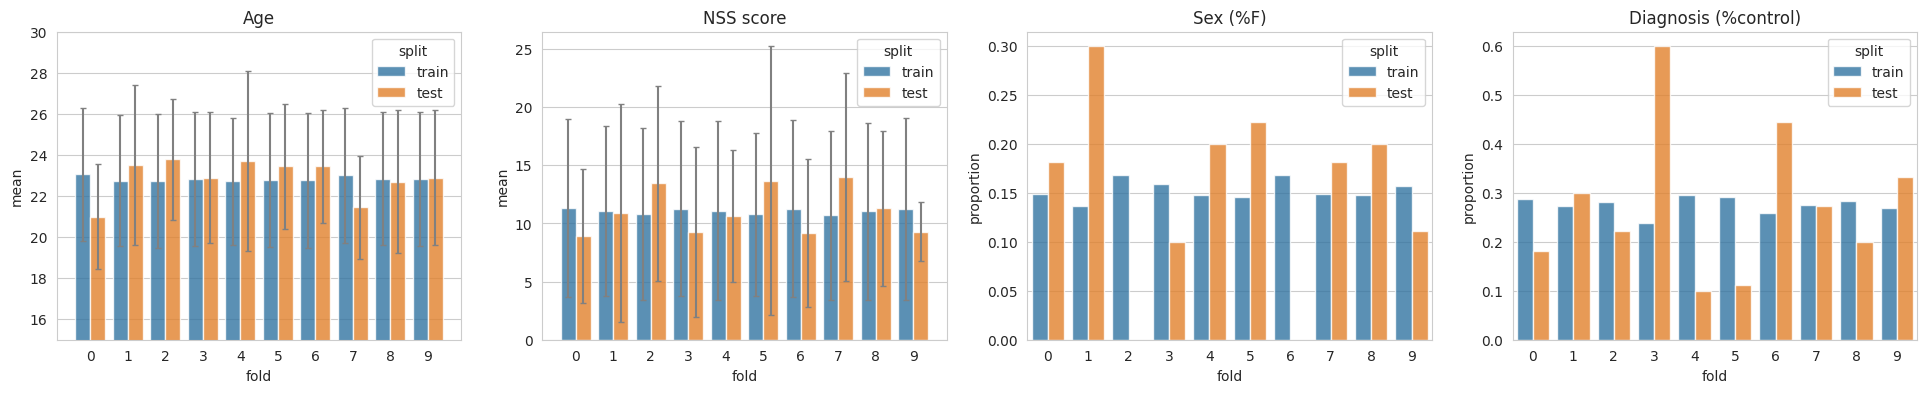

In [20]:
with sns.axes_style("whitegrid"):

    fig, ax = plt.subplots(1, 4, figsize=(24, 4))

    width = 0.2
    x = []
    for f in range(10):
        x.extend([f-width, f+width])
    sns.barplot(data=age_df, x="fold", y="mean", hue="split", ax=ax[0], alpha=0.8)
    ax[0].errorbar(x=x, y=age_df['mean'],
                yerr=age_df['std'], fmt='none', c= 'grey', capsize = 2)
    ax[0].set_ylim(15, 30)
    ax[0].set_title("Age")
    sns.barplot(data=nss_df, x="fold", y="mean", hue="split", ax=ax[1], alpha=0.8)
    ax[1].errorbar(x=x, y=nss_df['mean'],
                yerr=nss_df['std'], fmt='none', c= 'grey', capsize = 2)
    ax[1].set_title("NSS score")
    sns.barplot(data=sex_df, x="fold", y="proportion", hue="split", ax=ax[2], alpha=0.8)
    ax[2].set_title("Sex (%F)")
    sns.barplot(data=diag_df, x="fold", y="proportion", hue="split", ax=ax[3], alpha=0.8)
    ax[3].set_title("Diagnosis (%control)")

plt.show()

In [25]:
diff_nss = {"fold": [], "diff": []}
for fold in range(10):
    diff_nss["fold"].append(fold)
    diff_nss["diff"].append(np.abs(df.loc[scheme[f"fold{fold}"]=="train", "NSS"].mean() - df.loc[scheme[f"fold{fold}"]=="test", "NSS"].mean()))
diff_nss_df = pd.DataFrame(diff_nss)
print(diff_nss_df["diff"].mean())

1.813106750378641


### Stratification on NSS scores, sex and age

In [36]:
nss = {"fold":[], "split":[], "mean": [], "std": []}
age = {"fold":[], "split":[], "mean": [], "std": []}
sex = {"fold":[], "split":[], "proportion": []}
diag = {"fold":[], "split":[], "proportion": []}

new_df = pd.read_csv(os.path.join("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed", 
                                      "ausz_t1mri_participants.csv"), dtype=id_types)
new_scheme = pd.read_csv(os.path.join("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed", 
                                      "nss_sex_age_stratified_10_fold_ausz.csv"), dtype=id_types)

for fold in range(10):
    for split in ("train", "test"):
        
        # print("\nfold", fold, split, len(new_df.loc[scheme[f"fold{fold}"]==split]))
        
        nss["fold"].append(fold)
        nss["split"].append(split)
        nss["mean"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, "NSS"].mean())
        nss["std"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, "NSS"].std())

        age["fold"].append(fold)
        age["split"].append(split)
        age["mean"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, "age"].mean())
        age["std"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, "age"].std())

        sex["fold"].append(fold)
        sex["split"].append(split)
        sex["proportion"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, ["sex"]].value_counts(normalize=True).get("F", 0))

        diag["fold"].append(fold)
        diag["split"].append(split)
        diag["proportion"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, ["diagnosis"]].value_counts(normalize=True).get("control", 0))

nss_new_df = pd.DataFrame(nss)
age_new_df = pd.DataFrame(age)
sex_new_df = pd.DataFrame(sex)
diag_new_df = pd.DataFrame(diag)

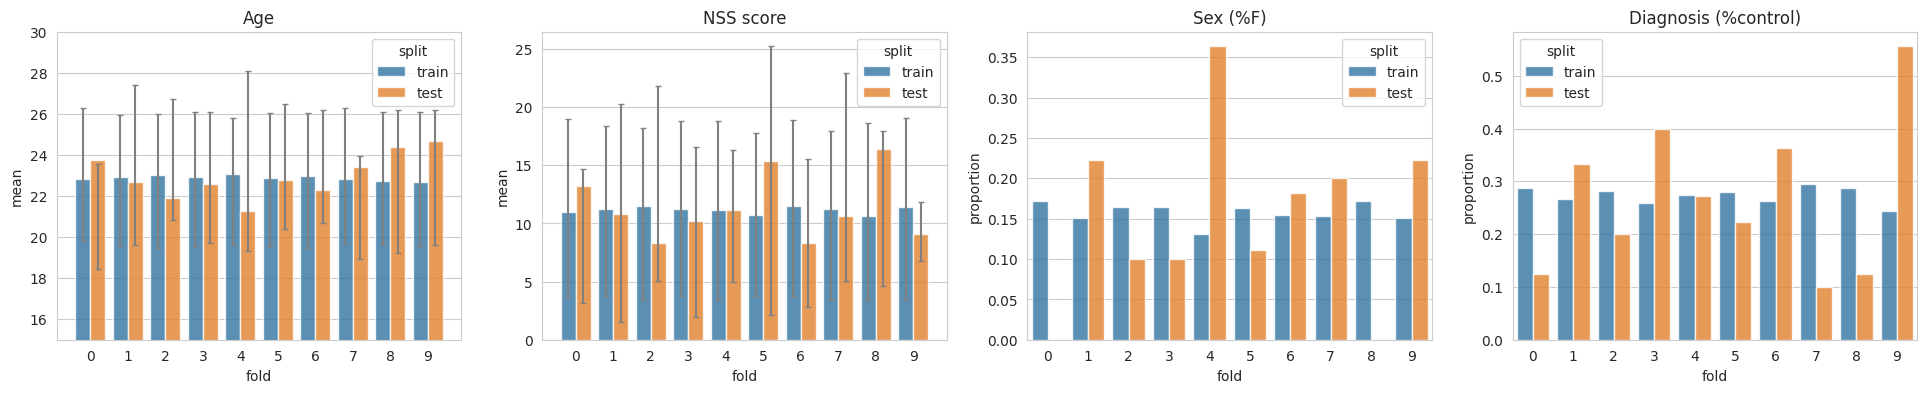

In [37]:
with sns.axes_style("whitegrid"):

    fig, ax = plt.subplots(1, 4, figsize=(24, 4))

    width = 0.2
    x = []
    for f in range(10):
        x.extend([f-width, f+width])
    sns.barplot(data=age_new_df, x="fold", y="mean", hue="split", ax=ax[0], alpha=0.8)
    ax[0].errorbar(x=x, y=age_df['mean'],
                yerr=age_df['std'], fmt='none', c= 'grey', capsize = 2)
    ax[0].set_ylim(15, 30)
    ax[0].set_title("Age")
    sns.barplot(data=nss_new_df, x="fold", y="mean", hue="split", ax=ax[1], alpha=0.8)
    ax[1].errorbar(x=x, y=nss_df['mean'],
                yerr=nss_df['std'], fmt='none', c= 'grey', capsize = 2)
    ax[1].set_title("NSS score")
    sns.barplot(data=sex_new_df, x="fold", y="proportion", hue="split", ax=ax[2], alpha=0.8)
    ax[2].set_title("Sex (%F)")
    sns.barplot(data=diag_new_df, x="fold", y="proportion", hue="split", ax=ax[3], alpha=0.8)
    ax[3].set_title("Diagnosis (%control)")

plt.show()

In [38]:
diff_nss = {"fold": [], "diff": []}
for fold in range(10):
    diff_nss["fold"].append(fold)
    diff_nss["diff"].append(np.abs(new_df.loc[new_scheme[f"fold{fold}"]=="train", "NSS"].mean() - new_df.loc[new_scheme[f"fold{fold}"]=="test", "NSS"].mean()))
diff_nss_df = pd.DataFrame(diff_nss)
print(diff_nss_df["diff"].mean())

2.3533873314459073


### Stratification only on NSS scores

In [40]:
nss = {"fold":[], "split":[], "mean": [], "std": []}
age = {"fold":[], "split":[], "mean": [], "std": []}
sex = {"fold":[], "split":[], "proportion": []}
diag = {"fold":[], "split":[], "proportion": []}

new_df = pd.read_csv(os.path.join("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed", 
                                      "ausz_t1mri_participants.csv"), dtype=id_types)
new_scheme = pd.read_csv(os.path.join("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed", 
                                      "nss_stratified_10_fold_ausz.csv"), dtype=id_types)

for fold in range(10):
    for split in ("train", "test"):
        
        # print("\nfold", fold, split, len(new_df.loc[scheme[f"fold{fold}"]==split]))
        
        nss["fold"].append(fold)
        nss["split"].append(split)
        nss["mean"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, "NSS"].mean())
        nss["std"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, "NSS"].std())

        age["fold"].append(fold)
        age["split"].append(split)
        age["mean"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, "age"].mean())
        age["std"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, "age"].std())

        sex["fold"].append(fold)
        sex["split"].append(split)
        sex["proportion"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, ["sex"]].value_counts(normalize=True).get("F", 0))

        diag["fold"].append(fold)
        diag["split"].append(split)
        diag["proportion"].append(new_df.loc[new_scheme[f"fold{fold}"]==split, ["diagnosis"]].value_counts(normalize=True).get("control", 0))

nss_new_df = pd.DataFrame(nss)
age_new_df = pd.DataFrame(age)
sex_new_df = pd.DataFrame(sex)
diag_new_df = pd.DataFrame(diag)

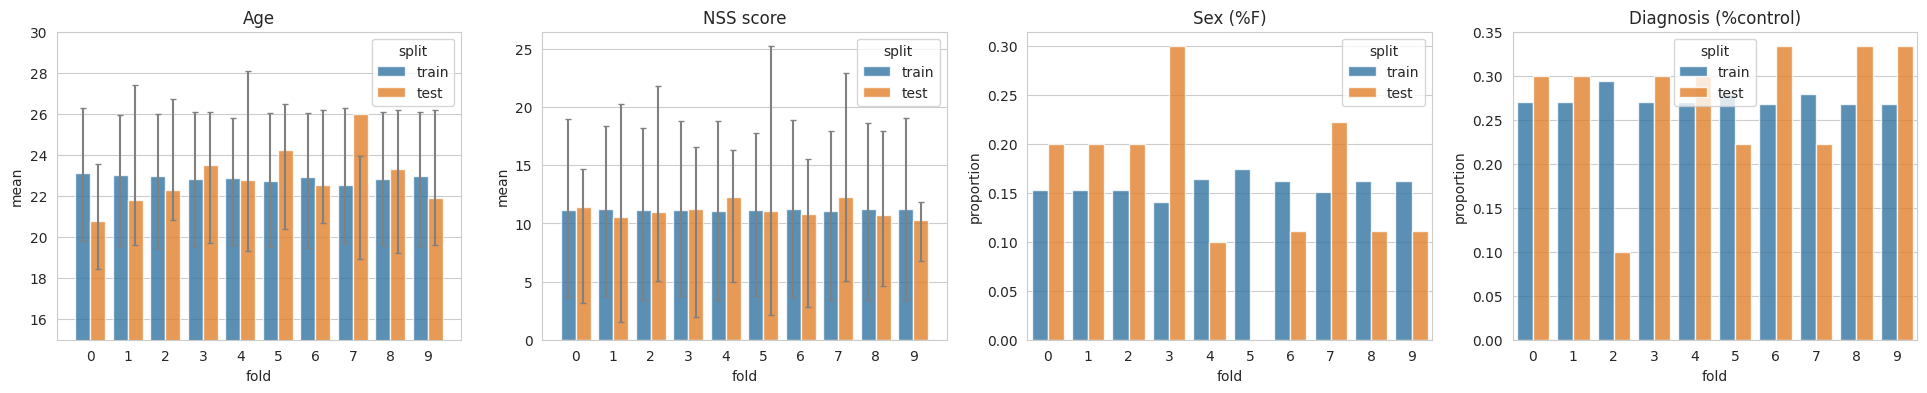

In [41]:
with sns.axes_style("whitegrid"):

    fig, ax = plt.subplots(1, 4, figsize=(24, 4))

    width = 0.2
    x = []
    for f in range(10):
        x.extend([f-width, f+width])
    sns.barplot(data=age_new_df, x="fold", y="mean", hue="split", ax=ax[0], alpha=0.8)
    ax[0].errorbar(x=x, y=age_df['mean'],
                yerr=age_df['std'], fmt='none', c= 'grey', capsize = 2)
    ax[0].set_ylim(15, 30)
    ax[0].set_title("Age")
    sns.barplot(data=nss_new_df, x="fold", y="mean", hue="split", ax=ax[1], alpha=0.8)
    ax[1].errorbar(x=x, y=nss_df['mean'],
                yerr=nss_df['std'], fmt='none', c= 'grey', capsize = 2)
    ax[1].set_title("NSS score")
    sns.barplot(data=sex_new_df, x="fold", y="proportion", hue="split", ax=ax[2], alpha=0.8)
    ax[2].set_title("Sex (%F)")
    sns.barplot(data=diag_new_df, x="fold", y="proportion", hue="split", ax=ax[3], alpha=0.8)
    ax[3].set_title("Diagnosis (%control)")

plt.show()

In [42]:
diff_nss = {"fold": [], "diff": []}
for fold in range(10):
    diff_nss["fold"].append(fold)
    diff_nss["diff"].append(np.abs(new_df.loc[new_scheme[f"fold{fold}"]=="train", "NSS"].mean() - new_df.loc[new_scheme[f"fold{fold}"]=="test", "NSS"].mean()))
diff_nss_df = pd.DataFrame(diff_nss)
print(diff_nss_df["diff"].mean())

0.5612144702842377


## Per diagnosis

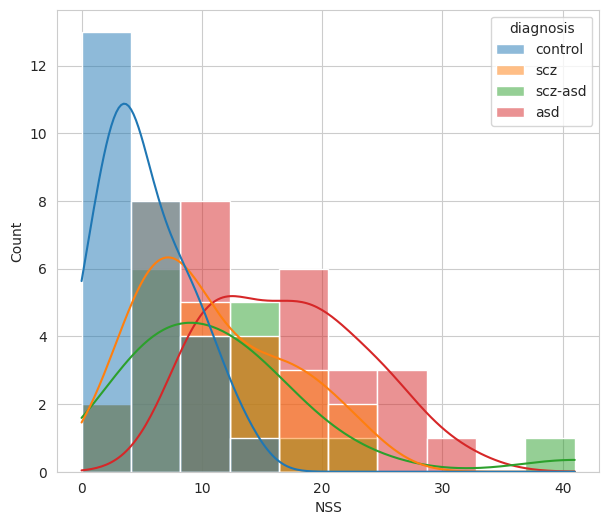

In [12]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    sns.histplot(data=df, x="NSS", hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"),
                kde=True, ax=ax)
plt.show()

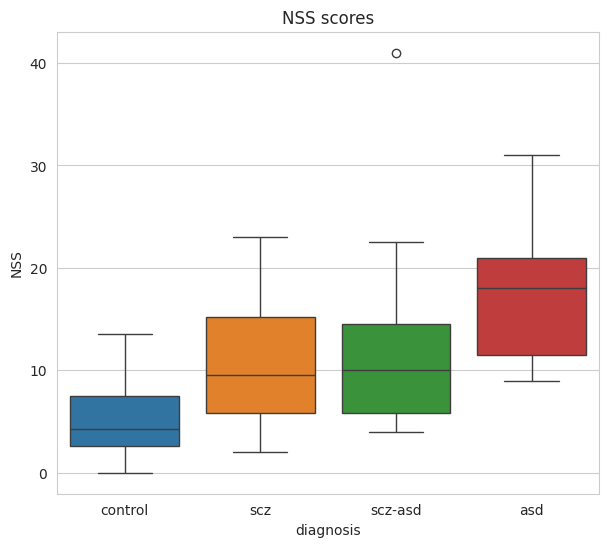

In [13]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    sns.boxplot(data=df, x="diagnosis", y="NSS", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax)
    ax.set_title("NSS scores")

plt.show()

In [ ]:
for diag in ("scz", "asd", "scz-asd"):
    y_pred = pd.concat((df.loc[df["diagnosis"] == "control", "NSS"], df.loc[df["diagnosis"] == diag, "NSS"]), axis=0).values
    y_true = np.array([0 for _ in range((df["diagnosis"]=="control").sum())] + [1 for _ in range((df["diagnosis"]==diag).sum())])
    print(diag, roc_auc_score(y_score=y_pred, y_true=y_true))

scz 0.7457264957264957
asd 0.9503703703703703
scz-asd 0.788888888888889


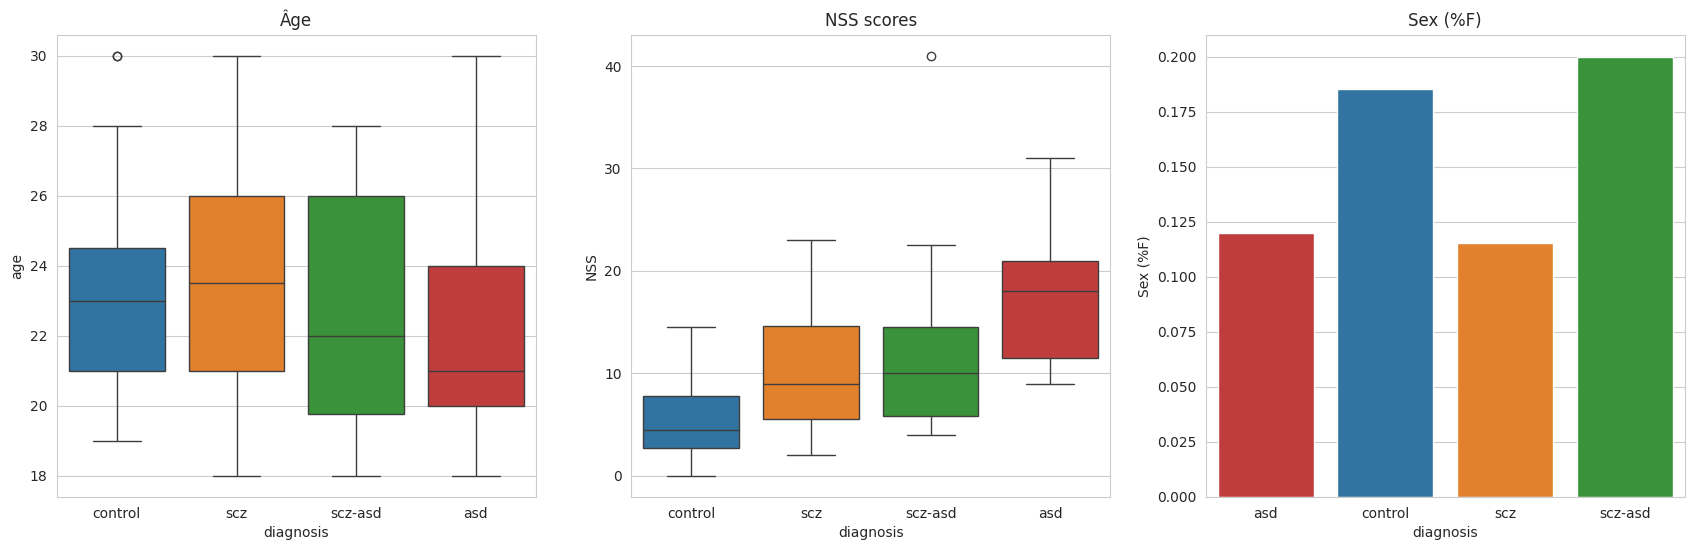

In [25]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))
    sns.boxplot(data=df, x="diagnosis", y="age", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax[0])
    ax[0].set_title("Âge")
    sns.boxplot(data=df, x="diagnosis", y="NSS", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax[1])
    ax[1].set_title("NSS scores")
    df["sex_encoded"] = df["sex"].replace({"M": 0, "m": 0, "F": 1}) 
    sns.barplot(data=df, x="diagnosis", y="sex_encoded", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), errorbar=None, ax=ax[2])
    ax[2].set_ylabel("Sex (%F)")
    ax[2].set_title("Sex (%F)")

plt.show()

In [29]:
df[["diagnosis", "NSS", "age"]].groupby("diagnosis").describe()

NSS                                                         age  \
          count       mean       std  min     25%   50%     75%   max count   
diagnosis                                                                     
asd        25.0  17.200000  6.253332  9.0  11.500  18.0  21.000  31.0  25.0   
control    27.0   5.500000  4.019185  0.0   2.750   4.5   7.750  14.5  27.0   
scz        26.0  10.307692  6.001795  2.0   5.500   9.0  14.625  23.0  26.0   
scz-asd    20.0  11.850000  8.527201  4.0   5.875  10.0  14.500  41.0  20.0   

                                                               
                mean       std   min    25%   50%   75%   max  
diagnosis                                                      
asd        21.960000  2.978814  18.0  20.00  21.0  24.0  30.0  
control    23.000000  3.000000  19.0  21.00  23.0  24.5  30.0  
scz        23.576923  3.624065  18.0  21.00  23.5  26.0  30.0  
scz-asd    22.700000  3.294333  18.0  19.75  22.0  26.0  28.0

In [15]:
df[["diagnosis", "sex"]].groupby("diagnosis").value_counts()

diagnosis  sex
asd        M      19
           F       3
           m       3
control    M      21
           F       5
           m       1
scz        M      23
           F       3
scz-asd    M      16
           F       4
Name: count, dtype: int64

In [37]:
threshold = 10
mask = (df["NSS"] > threshold)
df.loc[~mask, "diagnosis"].value_counts()

diagnosis
control    23
scz        14
scz-asd    10
asd         4
Name: count, dtype: int64

In [39]:
(21 + 10 + 10) / ((21 + 10 + 10) + (14 + 10 + 4))

0.5942028985507246

In [38]:
3 / (3 + 23)

0.11538461538461539

In [46]:
mask.sum() / len(mask)

0.4631578947368421

In [47]:
df

,Unnamed: 0,participant_id,session,run,sex,age,diagnosis,tiv,skeleton_size,site,...,DTD_1_AUTOQ_ITM_25_E1_C50,DTD_1_AUTOQ_ITM_26_E1_C50,DTD_1_AUTOQ_ITM_27_E1_C50,DTD_1_AUTOQ_ITM_28_E1_C50,DTDrelat,DTDcomm,DTDcomp,DTDdvpt,DTDTSA,DTDtot
0,0,LF130278,1,1,M,19.0,asd,1528.065680,34236,AUSZ,...,0.0,0.0,0.0,0.0,6.0,1.0,3.0,3.0,10.0,13.0
1,1,LA130256,1,1,M,22.0,control,1469.609340,38026,AUSZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,DC140291,1,1,M,20.0,scz,1973.513299,39690,AUSZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,CS130274,1,1,F,24.0,scz,1713.915132,35365,AUSZ,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,YR150471,1,1,M,19.0,control,1516.548036,35981,AUSZ,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,90,SB120158,1,1,M,21.0,scz-asd,1572.511485,38706,AUSZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,91,SY130215,1,1,M,24.0,control,1696.976540,37406,AUSZ,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,92,LA120178,1,1,M,21.0,asd,1702.724423,34217,AUSZ,...,0.0,0.0,0.0,0.0,5.0,1.0,1.0,2.0,7.0,9.0
93,93,DL140304,1,1,F,20.0,asd,1328.497681,33218,AUSZ,...,0.0,0.0,1.0,0.0,1.0,2.0,2.0,3.0,5.0,8.0
